In [102]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0
import folium

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import stats function for calculating pearson correlation coefficient
from scipy.stats.stats import pearsonr

#install wikipedia library
!conda install -c conda-forge wikipedia
import wikipedia as wp

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [120]:
#scrape wikipedia table from website into pandas data frame - instructor said you can use any method for this
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0,
                      keep_default_na=False)

headings = ['Postcode', 'Borough', 'Neighbourhood']
for table in tables:
    current_headings = table.columns.values[:4]
    if len(current_headings) != len(headings):
        continue
    if all(current_headings == headings):
        break
table.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [121]:
#dropping rows where Borough is 'Not assigned'
table.drop(table[table.Borough =='Not assigned'].index,inplace=True)
table.index=range(len(table.index))
table.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [122]:
#replacing not assigned Neighbourhoods to the same as Borough
table['Neighbourhood']=np.where(table['Neighbourhood']=='Not assigned',table['Borough'],table['Neighbourhood'])
table.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [123]:
#combine duplicated postcodes and combine neighbourhoods with same borough
grouped=table.groupby(by=['Postcode','Borough']).agg(lambda x: ','.join(x))
grouped.reset_index(level=['Postcode','Borough'],inplace=True)
grouped.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [124]:
#change column name to Postal Code to get ready for merging
toronto_grouped = grouped.rename(columns={'Postcode': 'Postal Code'})
toronto_grouped.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [125]:
#create data frame from Geospatial data of Toronto csv file
toronto_data = pd.read_csv('http://cocl.us/Geospatial_data')
toronto_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [126]:
#merge Geospatial data with neighbourhood data
toronto_merged = pd.merge(toronto_grouped,toronto_data,on='Postal Code')
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [127]:
#get geographical coordinates of Downtown Toronto
address = 'Downtown Toronto, Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto, Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto, Ontario are 43.6541737, -79.3808116451341.


In [128]:
#select only boroughs that in downtown Toronto
dttoronto_data=toronto_merged[toronto_merged['Borough']=="Downtown Toronto"]
dttoronto_data.reset_index(drop=True,inplace=True)
dttoronto_data

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568
9,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752


In [129]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(dttoronto_data['Latitude'], dttoronto_data['Longitude'], dttoronto_data['Borough'], dttoronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [130]:
CLIENT_ID = 'B4MPBB00HEYUWKJHWDMO4TWCVBZFA0B1Y5TE31NRRDAVLZCQ' # your Foursquare ID
CLIENT_SECRET = 'B2BVESULF5TI4TB3R5JU41Z3LJFJPD2ZBFRPBZPADWFHWRGP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B4MPBB00HEYUWKJHWDMO4TWCVBZFA0B1Y5TE31NRRDAVLZCQ
CLIENT_SECRET:B2BVESULF5TI4TB3R5JU41Z3LJFJPD2ZBFRPBZPADWFHWRGP


In [131]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius of 500m

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [132]:
dttoronto_venues = getNearbyVenues(names=dttoronto_data['Neighbourhood'],
                                   latitudes=dttoronto_data['Latitude'],
                                   longitudes=dttoronto_data['Longitude']
                                  )

Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie


In [133]:
print(dttoronto_venues.shape)
dttoronto_venues.head()

(1284, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown,St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [134]:
#count number of venues in each neighbourhood of Downtown Toronto
df_dttoronto_venuecount=dttoronto_venues.groupby('Neighbourhood').count()
df_venuecount_all=df_dttoronto_venuecount.reset_index()
df_venuecount_all

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide,King,Richmond",100,100,100,100,100,100
1,Berczy Park,55,55,55,55,55,55
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",14,14,14,14,14,14
3,"Cabbagetown,St. James Town",44,44,44,44,44,44
4,Central Bay Street,87,87,87,87,87,87
5,"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100
6,Christie,16,16,16,16,16,16
7,Church and Wellesley,88,88,88,88,88,88
8,"Commerce Court,Victoria Hotel",100,100,100,100,100,100
9,"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100


In [135]:
df_venuecount=pd.DataFrame(data=df_venuecount_all, columns=['Neighbourhood','Venue'])
df_venuecount

,Neighbourhood,Venue
0,"Adelaide,King,Richmond",100
1,Berczy Park,55
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",14
3,"Cabbagetown,St. James Town",44
4,Central Bay Street,87
5,"Chinatown,Grange Park,Kensington Market",100
6,Christie,16
7,Church and Wellesley,88
8,"Commerce Court,Victoria Hotel",100
9,"Design Exchange,Toronto Dominion Centre",100


In [136]:
df_venuecount_sorted=df_venuecount.sort_values('Venue',ascending=False)
df_venuecount_sorted

,Neighbourhood,Venue
0,"Adelaide,King,Richmond",100
8,"Commerce Court,Victoria Hotel",100
16,St. James Town,100
15,"Ryerson,Garden District",100
12,"Harbourfront East,Toronto Islands,Union Station",100
10,"First Canadian Place,Underground city",100
9,"Design Exchange,Toronto Dominion Centre",100
5,"Chinatown,Grange Park,Kensington Market",100
17,Stn A PO Boxes 25 The Esplanade,94
7,Church and Wellesley,88


### Looking at the table above with venue counts of each neighbourhood, there are 10 out of 17 neighbourhoods in Downtown Toronto that has an equal or higher number of venues than Central Bay Street, where the original coffee shop is located.

In [137]:
#select neighbourhoods with equal or more venues than Central Bay Street: drop rows/neighbourhoods with venue count less than 88
dttoronto_tv=dttoronto_venues[(dttoronto_venues['Neighbourhood']!='Berczy Park')&(dttoronto_venues['Neighbourhood']!='CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara')&(dttoronto_venues['Neighbourhood']!='Cabbagetown,St. James Town')&(dttoronto_venues['Neighbourhood']!='Christie')&(dttoronto_venues['Neighbourhood']!='Harbord,University of Toronto')&(dttoronto_venues['Neighbourhood']!='Harbourfront,Regent Park')&(dttoronto_venues['Neighbourhood']!='Rosedale')]
dttoronto_tv.shape

(1069, 7)

In [138]:
dttoronto_tv.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
48,Church and Wellesley,43.66586,-79.38316,Storm Crow Manor,43.666840,-79.381593,Theme Restaurant
49,Church and Wellesley,43.66586,-79.38316,DanceLifeX Centre,43.666956,-79.385297,Dance Studio
50,Church and Wellesley,43.66586,-79.38316,The Alley,43.665922,-79.385567,Bubble Tea Shop
51,Church and Wellesley,43.66586,-79.38316,Smith,43.666927,-79.381421,Breakfast Spot
52,Church and Wellesley,43.66586,-79.38316,Sansotei Ramen 三草亭,43.666735,-79.385353,Ramen Restaurant


In [139]:
dttoronto_tv.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Central Bay Street,87,87,87,87,87,87
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100
Church and Wellesley,88,88,88,88,88,88
"Commerce Court,Victoria Hotel",100,100,100,100,100,100
"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100
"First Canadian Place,Underground city",100,100,100,100,100,100
"Harbourfront East,Toronto Islands,Union Station",100,100,100,100,100,100
"Ryerson,Garden District",100,100,100,100,100,100


In [140]:
# one hot encoding
dttoronto_onehot = pd.get_dummies(dttoronto_tv[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dttoronto_onehot['Neighbourhood'] = dttoronto_tv['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [dttoronto_onehot.columns[-1]] + list(dttoronto_onehot.columns[:-1])
dttoronton_onehot = dttoronto_onehot[fixed_columns]

dttoronto_onehot.head(10)

,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Neighbourhood
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Church and Wellesley
49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Church and Wellesley
50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Church and Wellesley
51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [141]:
dttoronto_onehot.shape

(1069, 181)

In [142]:
dttoronto_grouped = dttoronto_onehot.groupby('Neighbourhood').mean().reset_index()
dttoronto_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.000000,0.040000,0.000000,0.00,0.010000,0.010000,0.000000,0.02,0.00,0.000000,0.030000,0.00,0.040000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.01,0.020000,0.00,0.000000,0.030000,0.010000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.060000,0.00,0.01,0.000000,0.000000,0.020000,0.00,0.030000,0.000000,0.01,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.01,0.00,0.01,0.000000,0.01,0.000000,0.020000,0.010000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.030000,0.00,0.00,0.010000,0.010000,0.000000,0.010000,0.020000,0.010000,0.010000,0.000000,0.00,0.01,0.00,0.000000,0.010000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.01,0.01,0.000000,0.01,0.000000,0.01,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.020000,0.01,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.020000,0.000000,0.020000,0.010000,0.000000,0.00,0.000000,0.010000,0.00,0.010000,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.000000,0.040000,0.000000,0.00,0.020000,0.00,0.000000,0.00,0.000000,0.040000,0.010000,0.000000,0.00,0.00,0.00,0.010000,0.000000,0.000000,0.010000,0.0

In [143]:
dttoronto_grouped.shape

(11, 181)

In [144]:
num_top_venues = 10

for hood in dttoronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = dttoronto_grouped[dttoronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3      Thai Restaurant  0.04
4           Steakhouse  0.04
5                  Bar  0.04
6               Bakery  0.03
7         Burger Joint  0.03
8                Hotel  0.03
9       Cosmetics Shop  0.03


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.16
1                Café  0.06
2  Italian Restaurant  0.05
3        Burger Joint  0.03
4                 Bar  0.02
5  Chinese Restaurant  0.02
6     Bubble Tea Shop  0.02
7    Sushi Restaurant  0.02
8      Ice Cream Shop  0.02
9   Indian Restaurant  0.02


----Chinatown,Grange Park,Kensington Market----
                           venue  freq
0                           Café  0.08
1  Vegetarian / Vegan Restaurant  0.06
2             Mexican Restaurant  0.04
3                            Bar  0.04
4            Dumpling Restaurant  0.04
5                    Coffee S

In [145]:
dttoronto_coffee=pd.DataFrame(data=dttoronto_grouped, columns=['Neighbourhood','Coffee Shop'])
dttoronto_coffee

,Neighbourhood,Coffee Shop
0,"Adelaide,King,Richmond",0.060000
1,Central Bay Street,0.160920
2,"Chinatown,Grange Park,Kensington Market",0.040000
3,Church and Wellesley,0.068182
4,"Commerce Court,Victoria Hotel",0.110000
5,"Design Exchange,Toronto Dominion Centre",0.120000
6,"First Canadian Place,Underground city",0.090000
7,"Harbourfront East,Toronto Islands,Union Station",0.120000
8,"Ryerson,Garden District",0.100000
9,St. James Town,0.070000


In [146]:
dttoronto_coffee_sorted=dttoronto_coffee.sort_values('Coffee Shop')
dttoronto_coffee_sorted.reset_index(drop=True,inplace=True)
dttoronto_coffee_sorted

,Neighbourhood,Coffee Shop
0,"Chinatown,Grange Park,Kensington Market",0.040000
1,"Adelaide,King,Richmond",0.060000
2,Church and Wellesley,0.068182
3,St. James Town,0.070000
4,"First Canadian Place,Underground city",0.090000
5,"Ryerson,Garden District",0.100000
6,Stn A PO Boxes 25 The Esplanade,0.106383
7,"Commerce Court,Victoria Hotel",0.110000
8,"Design Exchange,Toronto Dominion Centre",0.120000
9,"Harbourfront East,Toronto Islands,Union Station",0.120000


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


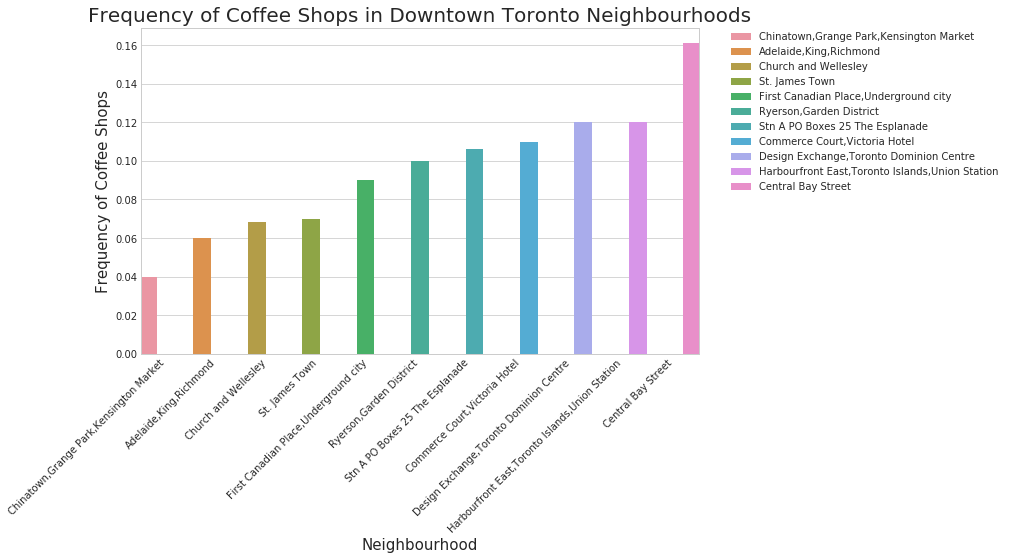

In [147]:
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

fig, ax = plt.subplots(figsize=(10,6))

fig=sns.barplot(data=dttoronto_coffee_sorted, x='Neighbourhood', y='Coffee Shop', ax=ax, hue='Neighbourhood')
ax.set_title('Frequency of Coffee Shops in Downtown Toronto Neighbourhoods', size=20)
ax.set_ylabel('Frequency of Coffee Shops', size=15)
ax.set_xlabel('Neighbourhood', size=15)
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, ha='right', size=5)
ax.tick_params(axis='both', labelsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)
plt.show()

In [148]:
dttoronto_top_neighbourhoods=list(dttoronto_coffee_sorted['Neighbourhood'])
dttoronto_top_neighbourhoods

['Chinatown,Grange Park,Kensington Market',
 'Adelaide,King,Richmond',
 'Church and Wellesley',
 'St. James Town',
 'First Canadian Place,Underground city',
 'Ryerson,Garden District',
 'Stn A PO Boxes 25 The Esplanade',
 'Commerce Court,Victoria Hotel',
 'Design Exchange,Toronto Dominion Centre',
 'Harbourfront East,Toronto Islands,Union Station',
 'Central Bay Street']

In [149]:
dttoronto_T=dttoronto_grouped.T
dttoronto_T.columns=dttoronto_T.iloc[0]
dttoronto_new=dttoronto_T.drop('Neighbourhood')
dttoronto_new.head(10)

Neighbourhood,"Adelaide,King,Richmond",Central Bay Street,"Chinatown,Grange Park,Kensington Market",Church and Wellesley,"Commerce Court,Victoria Hotel","Design Exchange,Toronto Dominion Centre","First Canadian Place,Underground city","Harbourfront East,Toronto Islands,Union Station","Ryerson,Garden District",St. James Town,Stn A PO Boxes 25 The Esplanade
Adult Boutique,0,0,0,0.0113636,0,0,0,0,0,0,0
Afghan Restaurant,0,0,0,0.0113636,0,0,0,0,0,0,0
American Restaurant,0.04,0.0114943,0,0.0113636,0.04,0.03,0.03,0,0.01,0.02,0
Antique Shop,0,0,0,0,0,0,0,0,0,0,0.0106383
Aquarium,0,0,0,0,0,0,0,0.05,0,0,0
Art Gallery,0.01,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.0212766
Art Museum,0.01,0.0114943,0,0,0,0,0,0,0,0,0
Arts & Crafts Store,0,0.0114943,0.01,0.0113636,0,0,0,0,0,0,0
Asian Restaurant,0.02,0,0,0,0,0.01,0.02,0,0,0,0
BBQ Joint,0,0,0,0,0,0,0,0,0,0.01,0


In [150]:
#Find Pearson correlation coefficient for Central Bay Street vs. other neighbourhoods
df_pearson=pd.DataFrame(columns=['Neighbourhood','Pearson Correlation Coefficient','P-value'])
for i in dttoronto_top_neighbourhoods:
    p_coef=pearsonr(dttoronto_new['Central Bay Street'],dttoronto_new[i])[0]
    p_value=pearsonr(dttoronto_new['Central Bay Street'],dttoronto_new[i])[1]
    print('Central Bay Street vs.',i,'- Pearson Correlation Coefficient:',p_coef,'; p-value:',p_value)
   
    df_pearson_new = df_pearson.append({
        'Neighbourhood': i,
        'Pearson Correlation Coefficient': p_coef,
        'P-value': p_value}, 
        ignore_index=True)
    df_pearson=df_pearson_new
df_pearson_new

Central Bay Street vs. Chinatown,Grange Park,Kensington Market - Pearson Correlation Coefficient: 0.41471282369 ; p-value: 7.12457464794e-09
Central Bay Street vs. Adelaide,King,Richmond - Pearson Correlation Coefficient: 0.571578315802 ; p-value: 5.30481465834e-17
Central Bay Street vs. Church and Wellesley - Pearson Correlation Coefficient: 0.512196888672 ; p-value: 1.99090887835e-13
Central Bay Street vs. St. James Town - Pearson Correlation Coefficient: 0.54902718981 ; p-value: 1.46466633106e-15
Central Bay Street vs. First Canadian Place,Underground city - Pearson Correlation Coefficient: 0.682062845351 ; p-value: 5.59623706839e-26
Central Bay Street vs. Ryerson,Garden District - Pearson Correlation Coefficient: 0.726424823601 ; p-value: 8.29399597435e-31
Central Bay Street vs. Stn A PO Boxes 25 The Esplanade - Pearson Correlation Coefficient: 0.649456479318 ; p-value: 6.10509242431e-23
Central Bay Street vs. Commerce Court,Victoria Hotel - Pearson Correlation Coefficient: 0.71570

,Neighbourhood,Pearson Correlation Coefficient,P-value
0,"Chinatown,Grange Park,Kensington Market",0.414713,7.124575e-09
1,"Adelaide,King,Richmond",0.571578,5.304815e-17
2,Church and Wellesley,0.512197,1.990909e-13
3,St. James Town,0.549027,1.464666e-15
4,"First Canadian Place,Underground city",0.682063,5.596237e-26
5,"Ryerson,Garden District",0.726425,8.293996e-31
6,Stn A PO Boxes 25 The Esplanade,0.649456,6.105092e-23
7,"Commerce Court,Victoria Hotel",0.715710,1.477158e-29
8,"Design Exchange,Toronto Dominion Centre",0.714348,2.110117e-29
9,"Harbourfront East,Toronto Islands,Union Station",0.696131,2.050364e-27


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


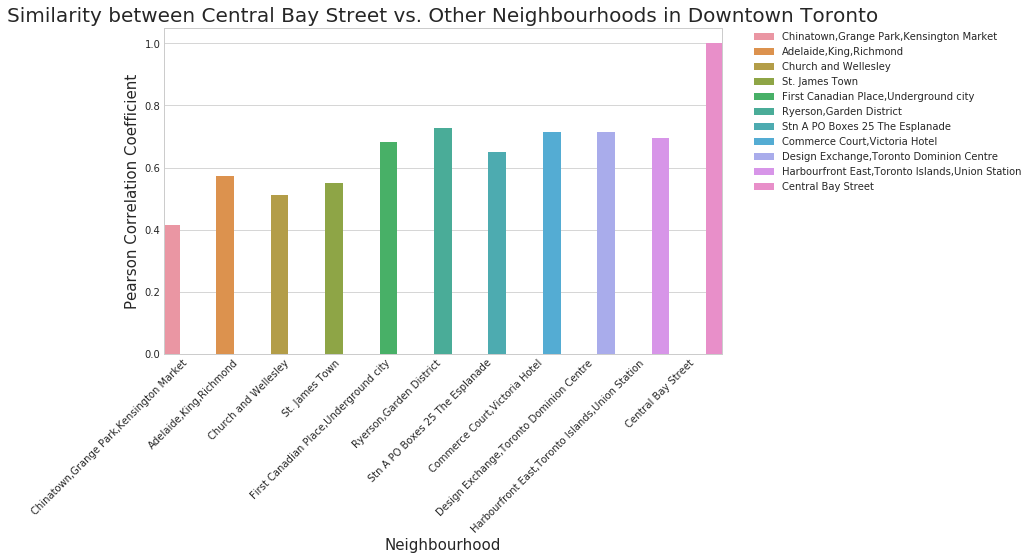

In [151]:
fig2, ax2 = plt.subplots(figsize=(10,6))

fig2=sns.barplot(data=df_pearson_new, x='Neighbourhood', y='Pearson Correlation Coefficient', ax=ax2, hue='Neighbourhood')
ax2.set_title('Similarity between Central Bay Street vs. Other Neighbourhoods in Downtown Toronto', size=20)
ax2.set_ylabel('Pearson Correlation Coefficient', size=15)
ax2.set_xlabel('Neighbourhood', size=15)
ax2.set_xticklabels(ax2.get_xmajorticklabels(), rotation=45, ha='right', size=5)
ax2.tick_params(axis='both', labelsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

change_width(ax2, .35)
plt.show()

In [152]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = dttoronto_grouped['Neighbourhood']

for ind in np.arange(dttoronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dttoronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,American Restaurant,Burger Joint,Cosmetics Shop,Bakery,Hotel
1,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Bar,Sushi Restaurant,Bakery,Chinese Restaurant,Japanese Restaurant
2,"Chinatown,Grange Park,Kensington Market",Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Bar,Dumpling Restaurant,Vietnamese Restaurant,Chinese Restaurant,Farmers Market
3,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel,Gym
4,"Commerce Court,Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Bakery,Italian Restaurant,Deli / Bodega,Seafood Restaurant,Steakhouse
5,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Hotel,Café,Restaurant,Deli / Bodega,Steakhouse,Bakery,Seafood Restaurant,Gastropub,Italian Restaurant
6,"First Canadian Place,Underground city",Coffee Shop,Café,Hotel,Bakery,Deli / Bodega,Burger Joint,Restaurant,Seafood Restaurant,Bar,Steakhouse
7,"Harbourfront East,Toronto Islands,Union Station",Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Fried Chicken Joint,Scenic Lookout,Pizza Place,Bakery,Restaurant
8,"Ryerson,Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Ramen Restaurant,Sporting Goods Shop,Bubble Tea Shop,Pizza Place,Italian Restaurant
9,St. James Town,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Bakery,Breakfast Spot,Gastropub,Clothing Store,Cocktail Bar


In [157]:
# set number of clusters
kclusters = 2

dttoronto_grouped_clustering = dttoronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dttoronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:11] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [158]:
dttoronto_data

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568
9,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752


In [159]:
#choose the 10 neighbourhoods with 88 venue counts or more
dttoronto_tvdata=dttoronto_data[(dttoronto_data['Neighbourhood']!='Berczy Park')&(dttoronto_data['Neighbourhood']!='CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara')&(dttoronto_data['Neighbourhood']!='Cabbagetown,St. James Town')&(dttoronto_data['Neighbourhood']!='Christie')&(dttoronto_data['Neighbourhood']!='Harbord,University of Toronto')&(dttoronto_data['Neighbourhood']!='Harbourfront,Regent Park')&(dttoronto_data['Neighbourhood']!='Rosedale')]
dttoronto_tvdata.reset_index(drop=True,inplace=True)
dttoronto_tvdata

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
4,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568
5,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752
6,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576
7,M5L,Downtown Toronto,"Commerce Court,Victoria Hotel",43.648198,-79.379817
8,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049
9,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846


In [160]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [161]:
dttoronto_merged = dttoronto_tvdata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dttoronto_merged = dttoronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

dttoronto_merged # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel,Gym
1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Ramen Restaurant,Sporting Goods Shop,Bubble Tea Shop,Pizza Place,Italian Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Bakery,Breakfast Spot,Gastropub,Clothing Store,Cocktail Bar
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Café,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Bar,Sushi Restaurant,Bakery,Chinese Restaurant,Japanese Restaurant
4,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,0,Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,American Restaurant,Burger Joint,Cosmetics Shop,Bakery,Hotel
5,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0,Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Fried Chicken Joint,Scenic Lookout,Pizza Place,Bakery,Restaurant
6,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,0,Coffee Shop,Hotel,Café,Restaurant,Deli / Bodega,Steakhouse,Bakery,Seafood Restaurant,Gastropub,Italian Restaurant
7,M5L,Downtown Toronto,"Commerce Court,Victoria Hotel",43.648198,-79.379817,0,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Bakery,Italian Restaurant,Deli / Bodega,Seafood Restaurant,Steakhouse
8,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,1,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Bar,Dumpling Restaurant,Vietnamese Restaurant,Chinese Restaurant,Farmers Market
9,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,0,Coffee Shop,Restaurant,Café,Italian Restaurant,Cocktail Bar,Hotel,Seafood Restaurant,Beer Bar,Fast Food Restaurant,Bakery


In [162]:
# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dttoronto_merged['Latitude'], dttoronto_merged['Longitude'], dttoronto_merged['Neighbourhood'], dttoronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [163]:
dttoronto_merged.loc[dttoronto_merged['Cluster Labels'] == 0, dttoronto_merged.columns[[2] + list(range(5, dttoronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Church and Wellesley,0,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel,Gym
1,"Ryerson,Garden District",0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Ramen Restaurant,Sporting Goods Shop,Bubble Tea Shop,Pizza Place,Italian Restaurant
2,St. James Town,0,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Bakery,Breakfast Spot,Gastropub,Clothing Store,Cocktail Bar
3,Central Bay Street,0,Coffee Shop,Café,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Bar,Sushi Restaurant,Bakery,Chinese Restaurant,Japanese Restaurant
4,"Adelaide,King,Richmond",0,Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,American Restaurant,Burger Joint,Cosmetics Shop,Bakery,Hotel
5,"Harbourfront East,Toronto Islands,Union Station",0,Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Fried Chicken Joint,Scenic Lookout,Pizza Place,Bakery,Restaurant
6,"Design Exchange,Toronto Dominion Centre",0,Coffee Shop,Hotel,Café,Restaurant,Deli / Bodega,Steakhouse,Bakery,Seafood Restaurant,Gastropub,Italian Restaurant
7,"Commerce Court,Victoria Hotel",0,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Bakery,Italian Restaurant,Deli / Bodega,Seafood Restaurant,Steakhouse
9,Stn A PO Boxes 25 The Esplanade,0,Coffee Shop,Restaurant,Café,Italian Restaurant,Cocktail Bar,Hotel,Seafood Restaurant,Beer Bar,Fast Food Restaurant,Bakery
10,"First Canadian Place,Underground city",0,Coffee Shop,Café,Hotel,Bakery,Deli / Bodega,Burger Joint,Restaurant,Seafood Restaurant,Bar,Steakhouse
